In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms



In [26]:
# Configuration
csv_file = "/home/jupyter/repos/cloudytile/sandbox/labels.csv"          # Path to your CSV
img_dir = "/home/jupyter/repos/cloudytile/data/2019cw_pngs/"       # Directory containing PNGs



In [22]:
# 1) Dataset Definition
class PNGDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row["label_num"], dtype=torch.float32)
        return image, label

# 2) Transforms
img_size = (128,128)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])



    
    

In [69]:
batch_size = 100
learning_rate = 0.001
num_epochs = 100
img_size = (128, 128)

In [70]:
# 3) DataLoaders
dataset = PNGDataset(csv_file, img_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)




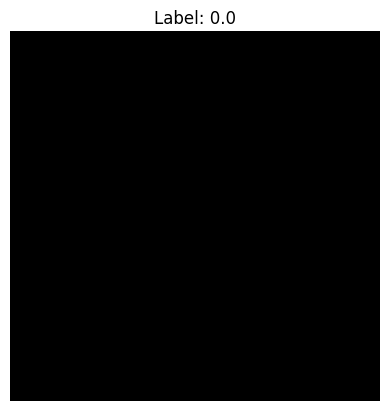

In [71]:
idx_img = 1

# 1) grab your batch
images, labels = next(iter(val_loader))

# 2) take the first image tensor
img = images[idx_img].cpu().detach()   # shape (3, H, W)

# 3) UN-normalize:  x_orig = x_norm * std + mean
img = img * 0.5 + 0.5

# 4) clamp to [0,1] just to be safe
img = img.clamp(0,1)

# 5) bring into HWC numpy for plotting
img_np = img.permute(1,2,0).numpy()

plt.imshow(img_np)
plt.title(f"Label: {labels[idx_img].item()}")
plt.axis("off")
plt.show()



In [72]:
# 4) Model Definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_size[0]//8) * (img_size[1]//8), 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)
    

In [73]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:







# 5) Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    epoch_loss = train_loss / train_total
    epoch_acc = train_correct / train_total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total
    print(f" Val  - Loss: {val_epoch_loss:.4f} - Acc: {val_epoch_acc:.4f}")



Epoch 1/100 - Loss: 0.5001 - Acc: 0.7534
 Val  - Loss: 0.3907 - Acc: 0.8554
Epoch 2/100 - Loss: 0.3631 - Acc: 0.8396
 Val  - Loss: 0.3521 - Acc: 0.8614
Epoch 3/100 - Loss: 0.3278 - Acc: 0.8533
 Val  - Loss: 0.3057 - Acc: 0.8554
Epoch 4/100 - Loss: 0.2933 - Acc: 0.8578
 Val  - Loss: 0.2860 - Acc: 0.8614
Epoch 5/100 - Loss: 0.2799 - Acc: 0.8578
 Val  - Loss: 0.2597 - Acc: 0.8675
Epoch 6/100 - Loss: 0.2582 - Acc: 0.8638
 Val  - Loss: 0.2524 - Acc: 0.8614
Epoch 7/100 - Loss: 0.2864 - Acc: 0.8366
 Val  - Loss: 0.2327 - Acc: 0.8614
Epoch 8/100 - Loss: 0.2410 - Acc: 0.8578
 Val  - Loss: 0.2278 - Acc: 0.8614
Epoch 9/100 - Loss: 0.2317 - Acc: 0.8714
 Val  - Loss: 0.2189 - Acc: 0.8614
Epoch 10/100 - Loss: 0.2353 - Acc: 0.8820
 Val  - Loss: 0.2445 - Acc: 0.8313
Epoch 11/100 - Loss: 0.7412 - Acc: 0.8064
 Val  - Loss: 1.2823 - Acc: 0.7169
Epoch 12/100 - Loss: 1.1129 - Acc: 0.7595
 Val  - Loss: 0.3312 - Acc: 0.8494
Epoch 13/100 - Loss: 0.3120 - Acc: 0.8563
 Val  - Loss: 0.2745 - Acc: 0.8614
Epoch 14